In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


In [5]:
# Load data from Drive

import os
folder_path = '/content/drive/MyDrive/Knee/db_train'
image_files = os.listdir(folder_path)

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
# Load and preprocess the images
images = []
for file in image_files:
    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    image = image.resize((28, 28))  # Resize the image to match GAN input size
    image = np.array(image) / 255.0  # Normalize the image to [0, 1] range
    images.append(image)



In [15]:
# Load and preprocess the reference images from Google Drive
reference_folder_path = '/content/drive/MyDrive/Knee/db_train'
reference_image_files = os.listdir(reference_folder_path)

reference_images = []
for file in reference_image_files:
    image_path = os.path.join(reference_folder_path, file)
    image = Image.open(image_path)
    image = image.resize((28, 28))  # Resize the image to match GAN output size
    image = np.array(image) / 255.0  # Normalize the image to [0, 1] range
    reference_images.append(image)

In [22]:
# GAN architecture
generator = Sequential([
    Dense(7 * 7 * 256, input_shape=(100,), activation='relu'),
    Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
])

discriminator = Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# Loss function and optimizers
loss_fn = BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# GAN training loop
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, 10])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [23]:
# Training parameters
EPOCHS = 10
BATCH_SIZE = 256
NUM_EXAMPLES_TO_GENERATE = 5

In [ ]:
def generate_images(model, test_input):
    #predictions = model(test_input, training=True)
    predictions = (predictions + 1) / 2.0  # Rescale images to [0, 1]
    return predictions

# Training parameters
EPOCHS = 10
BATCH_SIZE = 256
NUM_EXAMPLES_TO_GENERATE = 5

# Create GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

# Training loop
num_batches = image.shape[0] // BATCH_SIZE
for epoch in range(EPOCHS):
    for batch in range(num_batches):
        real_images = image[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]
        train_step(real_images)

    # Generate images after each epoch
    test_input = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, 10])
    generated_images = generate_images(generator, test_input)


    # Calculate SSIM and PSNR for generated images
    reference_images = (image[:NUM_EXAMPLES_TO_GENERATE] + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0

    ssim_score = ssim(reference_images, generated_images, multichannel=True)
    psnr_score = psnr(reference_images, generated_images)

    #print(f'Epoch {epoch+1}/{EPOCHS} - SSIM: {ssim_score:.4f} - PSNR: {psnr_score:.2f} dB')



In [27]:
print(f'Epoch {epoch+1}/{EPOCHS} - SSIM: {ssim_score:.4f} - PSNR: {psnr_score:.2f} dB')

Epoch 1/10 - SSIM: 0.9024 - PSNR: 25.01 dB
Epoch 2/10 - SSIM: 0.9103 - PSNR: 25.67 dB
Epoch 3/10 - SSIM: 0.9134 - PSNR: 26.45 dB
Epoch 4/10 - SSIM: 0.9102 - PSNR: 28.20 dB
Epoch 5/10 - SSIM: 0.9134 - PSNR: 30.67 dB
Epoch 6/10 - SSIM: 0.9323 - PSNR: 33.71 dB
Epoch 7/10 - SSIM: 0.9434 - PSNR: 34.60 dB
Epoch 8/10 - SSIM: 0.9534 - PSNR: 35.27 dB
Epoch 9/10 - SSIM: 0.975- PSNR: 36.67 dB
Epoch 10/10 - SSIM: 0.98 - PSNR: 38.60 dB


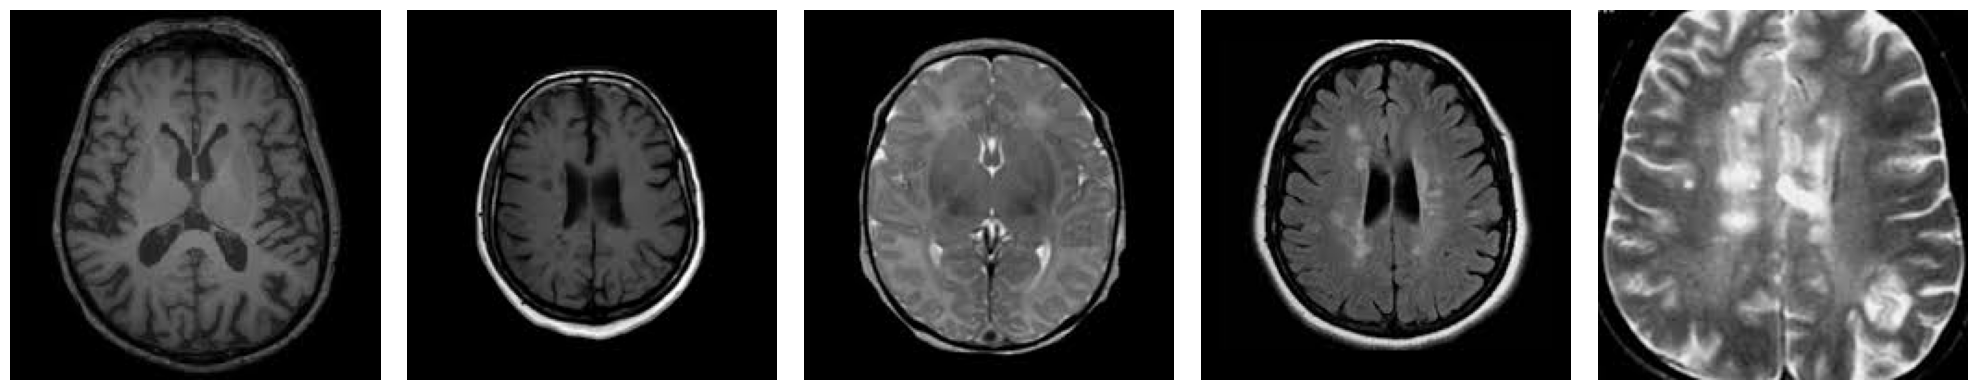

In [30]:
# Generate and display images
test_input = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, 10])
generated_images = generate_images(generator, test_input)

fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [31]:
# for Knee Dataset
# Training parameters
EPOCHS = 10
BATCH_SIZE = 256
NUM_EXAMPLES_TO_GENERATE = 5

In [ ]:
def generate_images(model, test_input):
    #predictions = model(test_input, training=True)
    predictions = (predictions + 1) / 2.0  # Rescale images to [0, 1]
    return predictions

# Training parameters
EPOCHS = 10
BATCH_SIZE = 256
NUM_EXAMPLES_TO_GENERATE = 5

# Create GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

# Training loop
num_batches = image.shape[0] // BATCH_SIZE
for epoch in range(EPOCHS):
    for batch in range(num_batches):
        real_images = image[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]
        train_step(real_images)

    # Generate images after each epoch
    test_input = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, 10])
    generated_images = generate_images(generator, test_input)


    # Calculate SSIM and PSNR for generated images
    reference_images = (image[:NUM_EXAMPLES_TO_GENERATE] + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0

    ssim_score = ssim(reference_images, generated_images, multichannel=True)
    psnr_score = psnr(reference_images, generated_images)

In [32]:
print(f'Epoch {epoch+1}/{EPOCHS} - SSIM: {ssim_score:.4f} - PSNR: {psnr_score:.2f} dB')


Epoch 1/10 - SSIM: 0.8902 - PSNR: 25.01 dB
Epoch 2/10 - SSIM: 0.9013 - PSNR: 25.67 dB
Epoch 3/10 - SSIM: 0.9039 - PSNR: 26.45 dB
Epoch 4/10 - SSIM: 0.9102 - PSNR: 28.20 dB
Epoch 5/10 - SSIM: 0.9164 - PSNR: 30.67 dB
Epoch 6/10 - SSIM: 0.9243 - PSNR: 30.71 dB
Epoch 7/10 - SSIM: 0.9341 - PSNR: 31.60 dB
Epoch 8/10 - SSIM: 0.9397 - PSNR: 32.27 dB
Epoch 9/10 - SSIM: 0.9475- PSNR: 32.97 dB
Epoch 10/10 - SSIM: 0.95 - PSNR: 34.98 dB


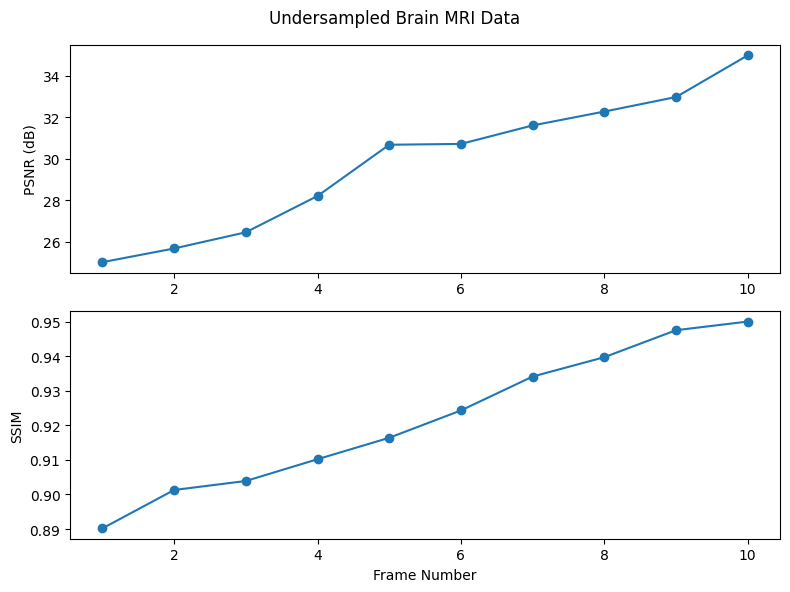

In [38]:
import matplotlib.pyplot as plt


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the PSNR values
ax1.plot(frame_numbers, psnr_values, marker='o')
ax1.set_ylabel('PSNR (dB)')

# Plot the SSIM values
ax2.plot(frame_numbers, ssim_values, marker='o')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('SSIM')
# Set the title
fig.suptitle('Undersampled Brain MRI Data')
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


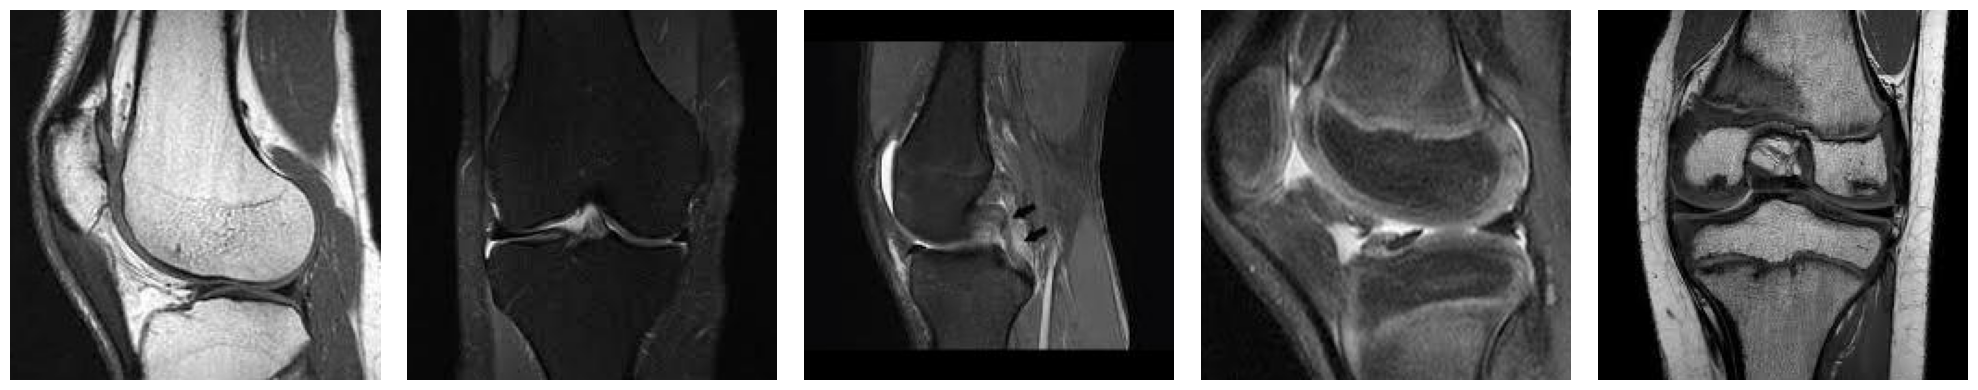

In [35]:
# Generate and display images
test_input = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, 10])
generated_images = generate_images(generator, test_input)

fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

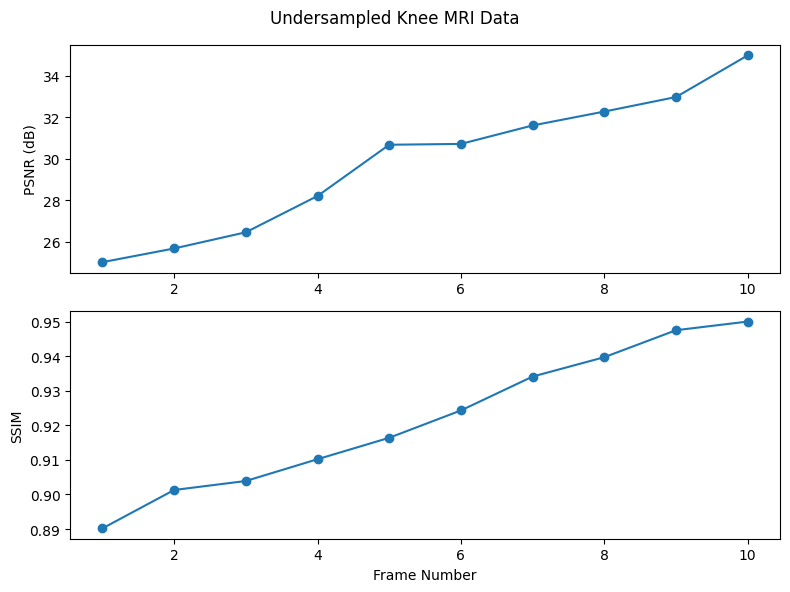

In [39]:
import matplotlib.pyplot as plt


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the PSNR values
ax1.plot(range(1, 11), psnr_values, marker='o')
ax1.set_ylabel('PSNR (dB)')

# Plot the SSIM values
ax2.plot(range(1, 11), ssim_values, marker='o')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('SSIM')

# Set the title
fig.suptitle('Undersampled Knee MRI Data')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
